In [86]:
import numpy as np
from blimpy import read_header, Waterfall, Filterbank

%matplotlib inline
import matplotlib.pyplot as plt

import sys, os, glob
sys.path.append("../../setigen")
import setigen as stg

tsamp = 1.0
fch1 = 6095.214842353016
df = -1.0e-06

fchans = 1024
tchans = 32

fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

In [9]:
# basic cnn training
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
from keras.preprocessing import image

# dimensions of our images.
img_width, img_height = 32, 1024

dir = 'scintillated_timescales_32_1024'

train_data_dir = '/datax/scratch/bbrzycki/data/%s/train/' % (dir)
validation_data_dir = '/datax/scratch/bbrzycki/data/%s/validation/' % (dir)
nb_train_samples = 1000*5
nb_validation_samples = 200*5
epochs = 50
batch_size = 64

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model_dir = '/datax/scratch/bbrzycki/models/%s/' % dir
model.load_weights(model_dir + '%s_v1.h5' % dir)

In [4]:
fn = '/datax/scratch/bbrzycki/data/blc00_guppi_58331_12383_DIAG_SGR_B2_0014.gpuspec.0000.fil'

3151.4433383530163 3151.442314353016
blimpy.file_wrapper WARNING  Given f_stop < f_start, assuming reversed values.


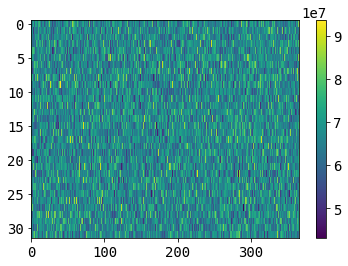

In [84]:
# Notable indices
# 198, 200
index = 21
fch1 = read_header(fn)[b'fch1']

f_start = fch1 + index * fchans * df
f_stop = fch1 + (index + 1) * fchans * df

print(f_start, f_stop)
frame = stg.get_data(Waterfall(fn, f_start=f_start, f_stop=f_stop))
normalized = stg.normalize(frame, cols = 128, exclude = 0.2, use_median=False)
plt.imshow(frame, aspect='auto')
plt.imsave('temp_observation.png', normalized)
plt.colorbar()

------
Short: 0.30%
Medium: 0.77%
Long: 92.37%
Constant: 6.56%
Noise: 0.00%


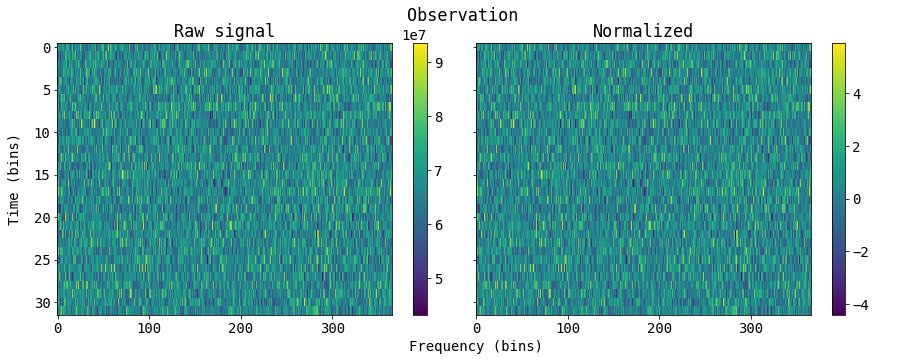

In [85]:
# start_index = np.random.randint(0,fchans)
# drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
#                                (fchans-1-start_index)*df/(tsamp*tchans))
# line_width = np.random.uniform(0.02, 0.05) ** 3
# level = np.random.uniform(1,5)

# signal = stg.generate(ts,
#                       fs,
#                       stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
#                       stg.constant_t_profile(level = 0),
#                       stg.gaussian_f_profile(width = line_width),
#                       stg.constant_bp_profile(level = 1.0))
# # fig = plt.figure(figsize=(10,6))
# # plt.imshow(signal, aspect='auto')
# # plt.colorbar()

# print('Drift Rate: %.02f Hz/s' % (drift_rate*1e6))
# print('Level: %.02f' % level)

# SET FONT
plt.rcParams.update({'font.family': 'monospace', 'font.size': 14})

# row and column sharing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharex='col', sharey='row')

img1a = ax1.imshow(frame, aspect='auto')
# plt.imsave('temp_no_noise.png', signal)
ax1.set_title('Raw signal')

# noisy = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)
img2a = ax2.imshow(normalized, aspect='auto')
plt.imsave('temp_normalized.png', normalized)
ax2.set_title('Normalized')

img2 = load_img('temp_normalized.png',False,target_size=(32,1024))
x = img_to_array(img2)
x = x / 255.
x = np.expand_dims(x, axis=0)
prob2 = model.predict_proba(x)[0]

# prob2 = (0.9567, 0.1083)
# prob3 = (0.9567, 0.1083, 0.0032)
# prob4 = (0.9567, 0.1083, 0.0032)

# if start_index < fchans / 2:
#     x_pos = 0.6
# else:
#     x_pos = 0.05

print('------')
print('Short: %.02f%%' % (prob2[4] * 100))
print('Medium: %.02f%%' % (prob2[2] * 100))
print('Long: %.02f%%' % (prob2[1] * 100))
print('Constant: %.02f%%' % (prob2[0] * 100))
print('Noise: %.02f%%' % (prob2[3] * 100))
    
# text = '{pulsed:<12} {value1:>7}\n{constant:<12} {value2:>7}'.format(pulsed='Present:',
#                                                                      value1='%.02f%%' % (prob2[1]*100),
#                                                                      constant='Not present:',
#                                                                      value2='%.02f%%' % (prob2[0]*100))    
# ax2.text(x_pos, 0.85, text, fontsize = 10, weight='bold', color='white', transform=ax2.transAxes,
#         bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

fig.suptitle('Observation')
plt.xlabel('Frequency (bins)')
plt.ylabel('Time (bins)')

plt.colorbar(img1a, ax = ax1)
plt.colorbar(img2a, ax = ax2)
# plt.tight_layout()

fig.subplots_adjust(wspace = 0.0)

plt.show()

In [ ]:
fch1 = read_header(fn)[b'fch1']
nchans = read_header(fn)[b'nchans']

notable_indices = []

for index in range(0, int(nchans / fchans)):
    f_stop = fch1 + index * fchans * df
    f_start = fch1 + (index + 1) * fchans * df
    frame = stg.get_data(Waterfall(fn, f_start=f_start, f_stop=f_stop))
    normalized = stg.normalize(frame, cols = 128, exclude = 0.2, use_median=False)
    
    # Predict each frame
    plt.imsave('temp_normalized.png', normalized)

    img = load_img('temp_normalized.png',False,target_size=(32, 1024))
    x = img_to_array(img)
    x = x / 255.
    x = np.expand_dims(x, axis=0)
    prob = model.predict_proba(x)[0]
    
    if prob[0] > 0.9:
        pass
#         notable_indices.append(index)
#         print('Found notable index: %s, constant' % index)
    elif prob[4] > 0.9:
        pass
#         notable_indices.append(index)
#         print('Found notable index: %s, short' % index)
    elif prob[2] > 0.9:
        notable_indices.append(index)
        print('Found notable index: %s, medium' % index)
    elif prob[1] > 0.9:
        pass
#         notable_indices.append(index)
#         print('Found notable index: %s, long' % index)
    else:
        pass
#         print('Index: %s, ???' % index)